In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 20;


<IPython.core.display.Javascript object>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import time

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score, classification_report
from yellowbrick.model_selection import FeatureImportances

import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Markdown, display

sns.set(style = 'white')

In [3]:
# data = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col='customerID')
data = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data = data.drop(columns=['customerID'])
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [4]:
data[data['tenure'] == 0]

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 No              No  No internet service   
936                 No             DSL                  Yes   
1082               Yes              No  No internet service   
1340  No phone service             DSL                  Yes   
3331                No              No  No internet service   
3826               Yes              No  No internet service   
4380                No              No  No internet service   
5218                No              No  No internet service   
6670               Yes             DSL                   No   
6754               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
488                    No                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                  Yes                   No   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
488                   Yes                   No  Two year              Yes   
753   No internet service  No internet service  Two year               No   
936                   Yes                  Yes  Two year               No   
1082  No internet service  No internet service  Two year               No   
1340                  Yes                   No  Two year               No   
3331  No internet service  No internet service  Two year               No   
3826  No internet service  No internet service  Two year               No   
4380  No internet service  No internet service  Two year               No   
5218  No internet service  No internet service  One year              Yes   
6670                  Yes                   No  Two year               No   
6754                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges Churn  
488   Bank transfer (automatic)           52.55           NaN    No  
753                Mailed check           20.25           NaN    No  
936                Mailed check           80.85           NaN    No  
1082               Mailed check           25.75           NaN    No  
1340    Credit card (automatic)           56.05           NaN    No  
3331               Mailed check           19.85           NaN    No  
3826               Mailed check           25.35           NaN    No  
4380               Mailed check           20.00           

There are `11` rows that does not have TotalCharges, and tenure is `zero`.
Drop them all

In [5]:
# data.dropna(subset=['TotalCharges'], inplace=True)
# parsed_shape = data.shape
# data.info()


Inspect data to check for remaining mission values and column with unique values

In [6]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [7]:
dataoveriew(data, 'Overview of the dataset')

Overview of the dataset:

Rows: 7043

Number of features: 20

Features:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values: 11

Unique values:
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64


View profile report to get more insight

In [8]:
# import pandas_profiling as pp
# import ydata_profiling as pp

# profile = pp.ProfileReport(data)
# profile


1. **Gender Distribution** 

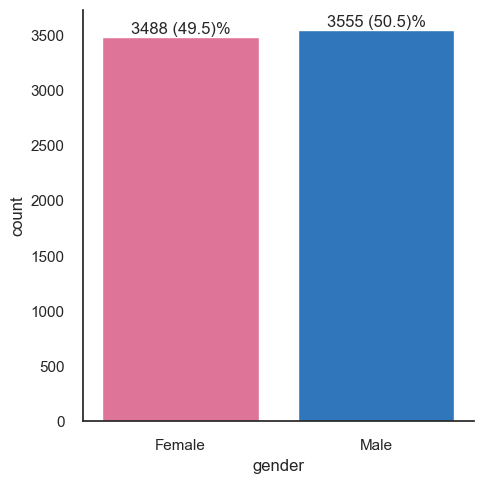

In [9]:
g = sns.catplot(x="gender", kind="count", palette=['#F06292', '#1976D2'],data=data)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    totals = sum([int(v.get_height()) for v in c])
    labels = [f'{int(v.get_height()) } ' + f'({(v.get_height() / totals * 100):.1f})%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()

## Senior Status

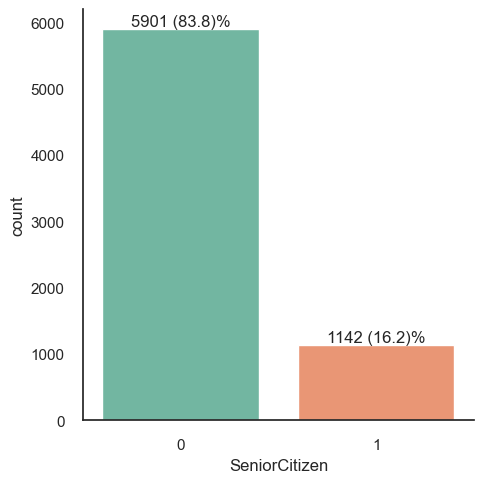

In [10]:

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

    
g = sns.catplot(x="SeniorCitizen", kind="count", palette='Set2',data=data)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    totals = sum([int(v.get_height()) for v in c])
    labels = [f'{int(v.get_height()) } ' + f'({(v.get_height() / totals * 100):.1f})%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

    
plt.show()

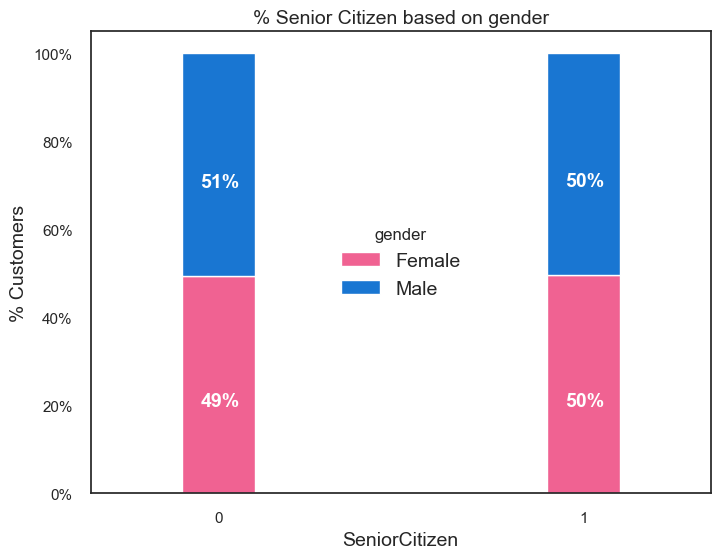

In [11]:
colors = ['#F06292', '#1976D2']
partner_dependents = data.groupby(['SeniorCitizen','gender']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'gender',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Senior Citizen based on gender',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

## Dependents

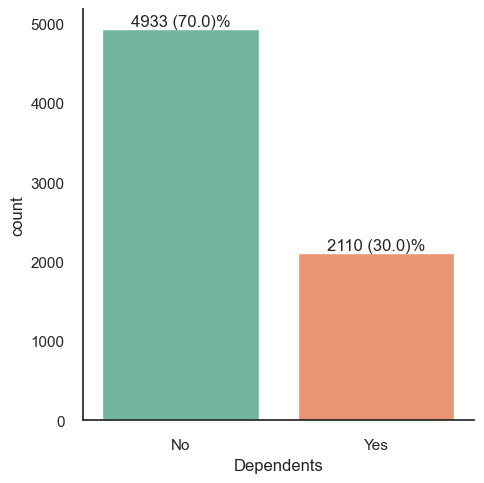

In [12]:

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

    
g = sns.catplot(x="Dependents", kind="count", palette='Set2',data=data)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    totals = sum([int(v.get_height()) for v in c])
    labels = [f'{int(v.get_height()) } ' + f'({(v.get_height() / totals * 100):.1f})%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

    
plt.show()

## Partner

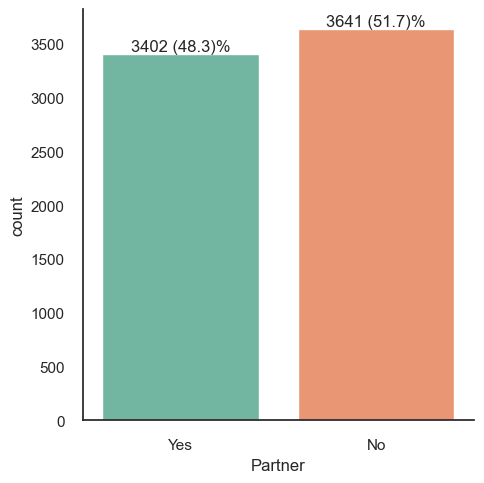

In [13]:
# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

    
g = sns.catplot(x="Partner", kind="count", palette='Set2',data=data)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    totals = sum([int(v.get_height()) for v in c])
    labels = [f'{int(v.get_height()) } ' + f'({(v.get_height() / totals * 100):.1f})%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

    
plt.show()

# Customer dependents based on whether they have partner

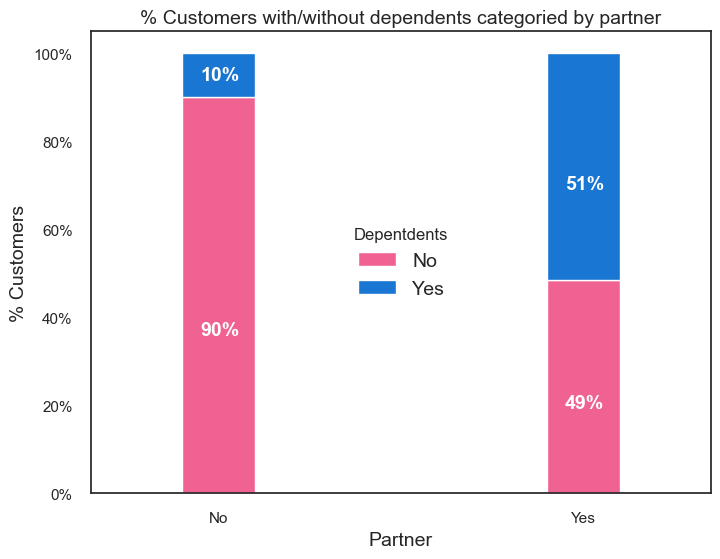

In [14]:
colors = ['#F06292', '#1976D2']
partner_dependents = data.groupby(['Partner','Dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Depentdents',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without dependents categoried by partner',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

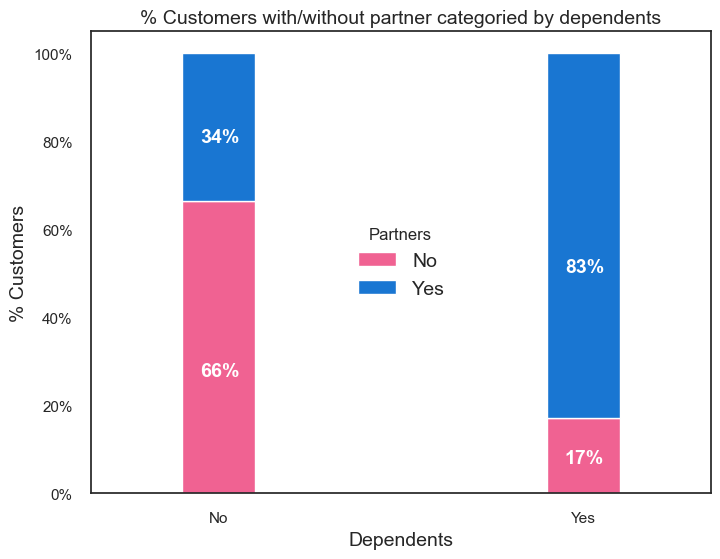

In [15]:
colors = ['#F06292', '#1976D2']
partner_dependents = data.groupby(['Dependents', 'Partner']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Partners',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without partner categoried by dependents',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

## Payment Distribution

In [16]:
# fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])
# fig.add_trace(go.Pie(labels=data['PaymentMethod'].value_counts().index, values=data['PaymentMethod'].value_counts().values, name="PaymentMethod"),
#               1, 1)
# fig.add_trace(go.Pie(labels=data['Contract'].value_counts().index, values=data['Contract'].value_counts().values, name="Contract"),
#               1, 2)
display(px.pie(data['PaymentMethod'].value_counts().reset_index().rename(columns={'index':'Type'}), values='PaymentMethod', names='Type', title='Payment Method Distribution', color_discrete_sequence=px.colors.qualitative.Set2))

# printmd("#### Majority of the customers use E-check")

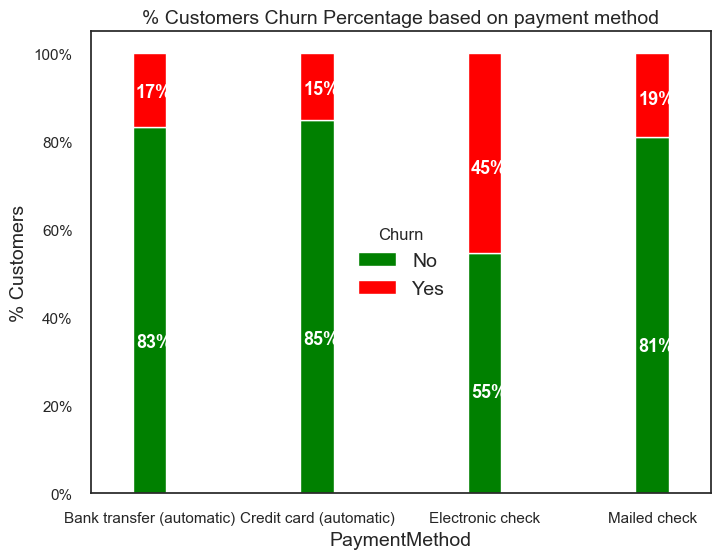

In [17]:
colors = ['green', 'red'] # No, YES

partner_dependents = data.groupby(['PaymentMethod', 'Churn']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers Churn Percentage based on payment method',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.1*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 13)

# Contract Type

In [18]:
display(px.pie(data['Contract'].value_counts().reset_index().rename(columns={'index':'Type'}), values='Contract', names='Type', title='Contract Distribution', color_discrete_sequence=px.colors.qualitative.Set2))


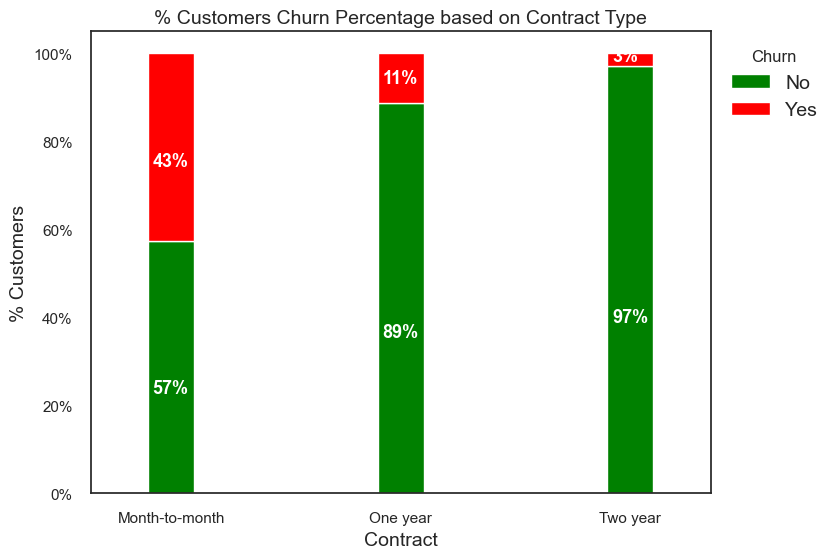

In [19]:
colors = ['green', 'red'] # No, YES

partner_dependents = data.groupby(['Contract', 'Churn']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn',fontsize =14, bbox_to_anchor=(1.2,1))
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers Churn Percentage based on Contract Type',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.1*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 13)

## PaperlessBilling

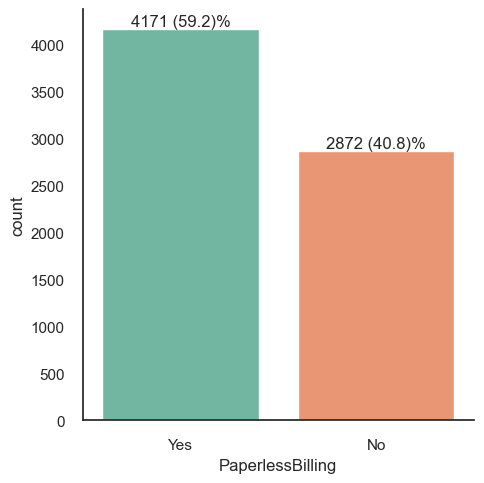

In [20]:
g = sns.catplot(x="PaperlessBilling", kind="count", palette='Set2',data=data)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    totals = sum([int(v.get_height()) for v in c])
    labels = [f'{int(v.get_height()) } ' + f'({(v.get_height() / totals * 100):.1f})%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()


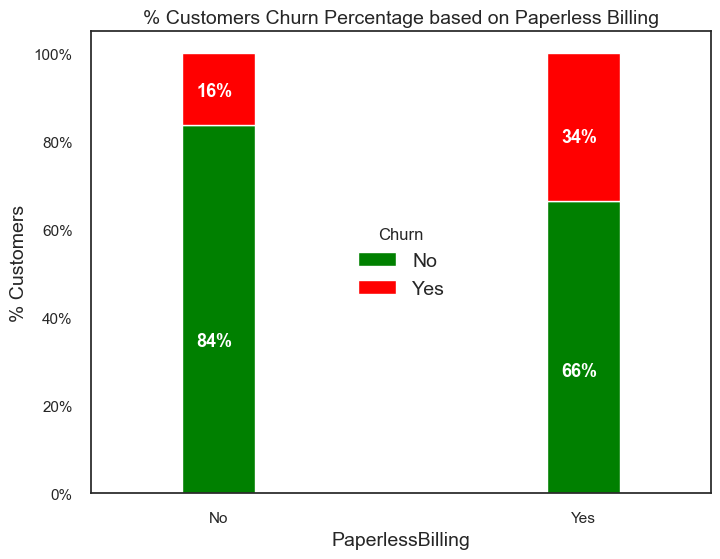

In [21]:
colors = ['green', 'red'] # No, YES

partner_dependents = data.groupby(['PaperlessBilling', 'Churn']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers Churn Percentage based on Paperless Billing',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.2*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 13)

## OnlineSecurity and OnlineBackup

In [22]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=data['OnlineSecurity'].value_counts().index, values=data['OnlineSecurity'].value_counts().values, name="Online Security"),
              1, 1)
fig.add_trace(go.Pie(labels=data['OnlineBackup'].value_counts().index, values=data['OnlineBackup'].value_counts().values, name="Online Backup"),
              1, 2)


# donut-like pie chart
fig.update_traces(hole=.5, hoverinfo="label+percent")

fig.update_layout(

    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Online<br>Security', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Online<br>Backup', x=0.804, y=0.5, font_size=20, showarrow=False),
                
                ]),
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0), legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="left",
    x=0.4
))
fig.show()



# printmd("### 'Online Backup', 'Device Protection' and 'Online Security', 'Tech Support' has similar distribution")

## DeviceProtection and TechSupport

In [23]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=data['DeviceProtection'].value_counts().index, values=data['DeviceProtection'].value_counts().values, name="Device Protection"),
              1, 1)
fig.add_trace(go.Pie(labels=data['TechSupport'].value_counts().index, values=data['TechSupport'].value_counts().values, name="Tech Support"),
              1, 2)

# donut-like pie chart
fig.update_traces(hole=.5, hoverinfo="label+percent")

fig.update_layout(

    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Device<br>Protection', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Tech<br>Backup', x=0.804, y=0.5, font_size=20, showarrow=False),
                ]),
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0), legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="left",
    x=0.4
))
fig.show()



# printmd("### 'Online Backup', 'Device Protection' and 'Online Security', 'Tech Support' has similar distribution")

## StreamingTV and StreamingMovies

In [24]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])


fig.add_trace(go.Pie(labels=data['StreamingTV'].value_counts().index, values=data['StreamingTV'].value_counts().values, name="Streaming TV"),
              1, 1)
fig.add_trace(go.Pie(labels=data['StreamingMovies'].value_counts().index, values=data['StreamingMovies'].value_counts().values, name="Streaming Movies"),
              1, 2)

# fig.add_trace(go.Pie(labels=data['MultipleLines'].value_counts().index, values=data['MultipleLines'].value_counts().values, name="MultipleLines"),
#               4, 1)
# fig.add_trace(go.Pie(labels=data['InternetService'].value_counts().index, values=data['InternetService'].value_counts().values, name="Internet Service"),
#               4, 2)

# donut-like pie chart
fig.update_traces(hole=.5, hoverinfo="label+percent")

fig.update_layout(

    # Add annotations in the center of the donut pies.
    annotations=[dict(text='StreamingTV', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Streaming<br>Movies', x=0.834, y=0.5, font_size=20, showarrow=False),
#                  dict(text='Multiple<br>Lines', x=0.805, y=0.18, font_size=20, showarrow=False),
#                  dict(text='Internet<br>Service', x=0.805, y=0.18, font_size=20, showarrow=False),
                
                ]),
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0), legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="left",
    x=0.4
))
fig.show()



# printmd("### 'Online Backup', 'Device Protection' and 'Online Security', 'Tech Support' has similar distribution")

## PhoneService and MultipleLines

In [25]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])


fig.add_trace(go.Pie(labels=data['PhoneService'].value_counts().index, values=data['PhoneService'].value_counts().values, name="Streaming TV"),
              1, 1)
fig.add_trace(go.Pie(labels=data['MultipleLines'].value_counts().index, values=data['MultipleLines'].value_counts().values, name="Streaming Movies"),
              1, 2)

# fig.add_trace(go.Pie(labels=data['MultipleLines'].value_counts().index, values=data['MultipleLines'].value_counts().values, name="MultipleLines"),
#               4, 1)
# fig.add_trace(go.Pie(labels=data['InternetService'].value_counts().index, values=data['InternetService'].value_counts().values, name="Internet Service"),
#               4, 2)

# donut-like pie chart
fig.update_traces(hole=.5, hoverinfo="label+percent")

fig.update_layout(

    # Add annotations in the center of the donut pies.
    annotations=[dict(text='PhoneService', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='MultipleLines', x=0.834, y=0.5, font_size=20, showarrow=False),
                
                ]),
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0), legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="left",
    x=0.4
))
fig.show()



# printmd("### 'Online Backup', 'Device Protection' and 'Online Security', 'Tech Support' has similar distribution")

## InternetService

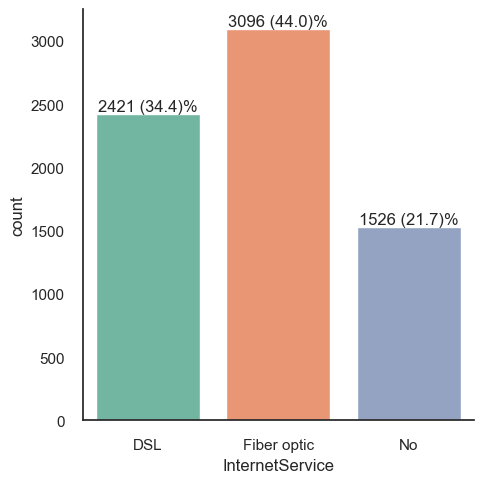

In [26]:
g = sns.catplot(x="InternetService", kind="count", palette='Set2',data=data)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    totals = sum([int(v.get_height()) for v in c])
    labels = [f'{int(v.get_height()) } ' + f'({(v.get_height() / totals * 100):.1f})%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()


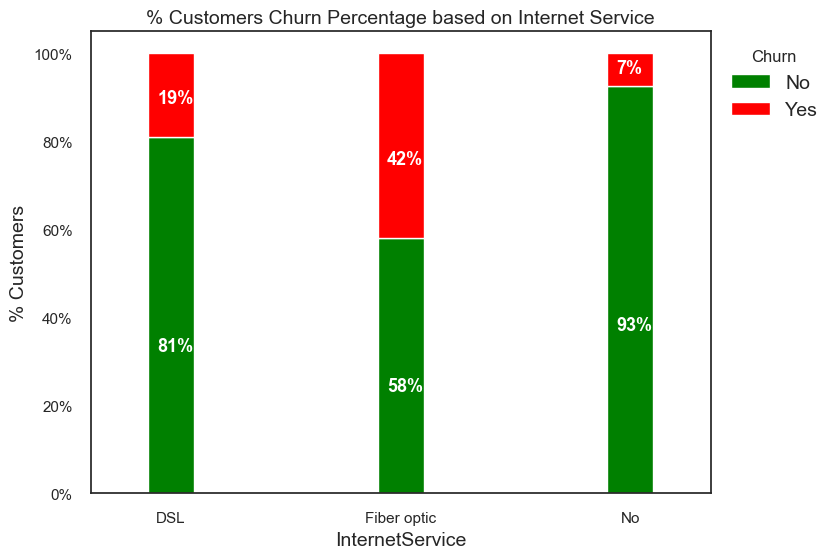

In [27]:
colors = ['green', 'red'] # No, YES

partner_dependents = data.groupby(['InternetService', 'Churn']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn',fontsize =14, bbox_to_anchor=(1.2,1))
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers Churn Percentage based on Internet Service',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.2*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 13)

## Monthly Charge

In [28]:
feature = 'MonthlyCharges'
# Create subplot object
fig = make_subplots(
    rows=1,
    cols=2,
    print_grid=False,
subplot_titles=(f"Distribution of {feature} ($) with Histogram", f"Distribution of {feature} ($) with Box Plot"))

# This is a count histogram
fig.add_trace(
    go.Histogram(
        x = data[feature],
        hoverinfo="x+y"
    ),
row=1,col=1)

# This is a density histogram
fig.add_trace(
    go.Box(y=data[feature]),
#     sns.boxplot(x=data["TotalCharges"]),
row=1,col=2)

# Update layout
fig.layout.update(
#     height=800, 
    width=1200,
    hovermode="closest"
    )

# Update axesbb
fig.layout.yaxis1.update(title="<b>Abs Frequency</b>")
fig.layout.yaxis2.update(title="<b>Dollars($)</b>")
fig.layout.xaxis1.update(title=f"<b>{feature} ($)</b>")
fig.layout.xaxis2.update(title=f"<b>{feature}</b>")

fig.show()

## TotalCharges

In [29]:
feature = 'TotalCharges'
# Create subplot object
fig = make_subplots(
    rows=1,
    cols=2,
    print_grid=False,
subplot_titles=(f"Distribution of {feature} ($) with Histogram", f"Distribution of {feature} ($) with Box Plot"))

# This is a count histogram
fig.add_trace(
    go.Histogram(
        x = data[feature],
        hoverinfo="x+y"
    ),
row=1,col=1)

# This is a density histogram
fig.add_trace(
    go.Box(y=data[feature]),
#     sns.boxplot(x=data["TotalCharges"]),
row=1,col=2)

# Update layout
fig.layout.update(
#     height=800, 
    width=1200,
    hovermode="closest"
    )

# Update axes
fig.layout.yaxis1.update(title="<b>Abs Frequency</b>")
fig.layout.yaxis2.update(title="<b>Dollars($)</b>")
fig.layout.xaxis1.update(title=f"<b>{feature} ($)</b>")
fig.layout.xaxis2.update(title=f"<b>{feature}</b>")

fig.show()

## TotalChanges and MonthlyCharges

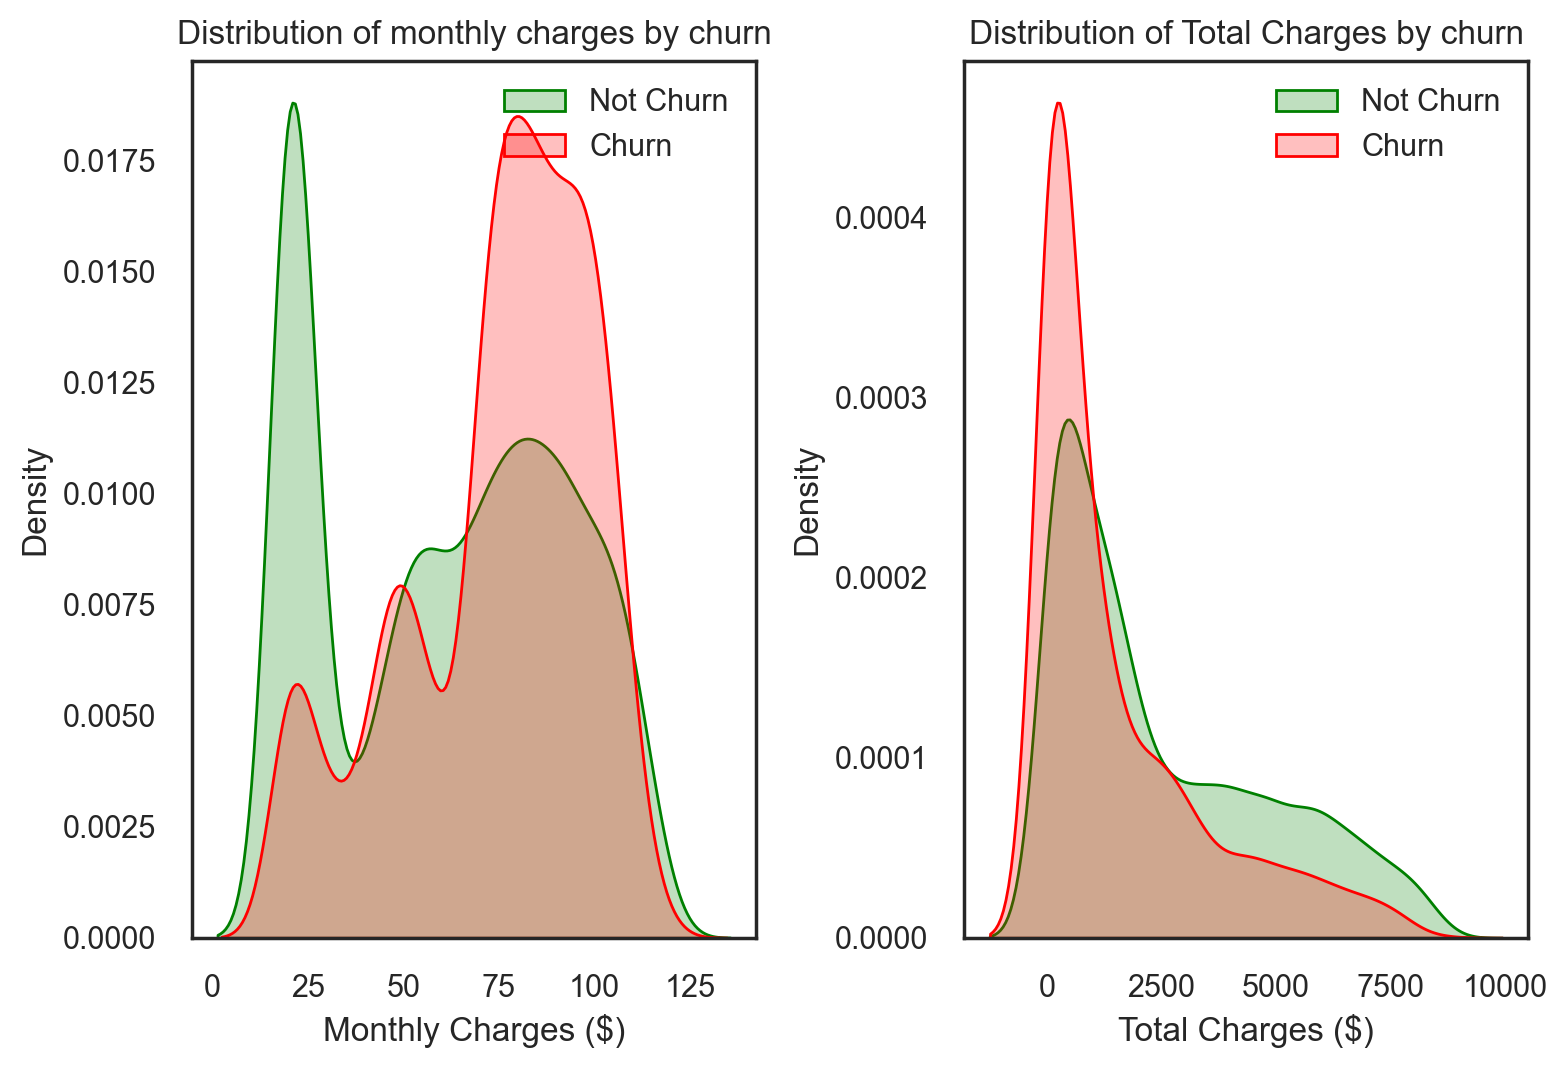

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=200)


ax = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == 'No') ],
                color="green", shade = True, ax=axs[0])
ax = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="red", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges ($)')
ax.set_title('Distribution of monthly charges by churn')

ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'No') ],
                color="green", shade = True, ax=axs[1])
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="red", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges ($)')
ax.set_title('Distribution of Total Charges by churn')
fig.tight_layout()


## tennure

In [31]:
feature = 'tenure'
# Create subplot object
fig = make_subplots(
    rows=1,
    cols=2,
    print_grid=False,
subplot_titles=(f"Distribution of {feature} (months) with Histogram", f"Distribution of {feature} (months) with Box Plot"))

# This is a count histogram
fig.add_trace(
    go.Histogram(
        x = data[feature],
        hoverinfo="x+y"
    ),
row=1,col=1)

# This is a density histogram
fig.add_trace(
    go.Box(y=data[feature]),
#     sns.boxplot(x=data["TotalCharges"]),
row=1,col=2)

# Update layout
fig.layout.update(
#     height=800, 
    width=1200,
    hovermode="closest"
    )

# Update axes
fig.layout.yaxis1.update(title="<b>Abs Frequency</b>")
fig.layout.yaxis2.update(title="<b>Months</b>")
fig.layout.xaxis1.update(title=f"<b>{feature} (months)</b>")
fig.layout.xaxis2.update(title=f"<b>{feature}</b>")

fig.show()

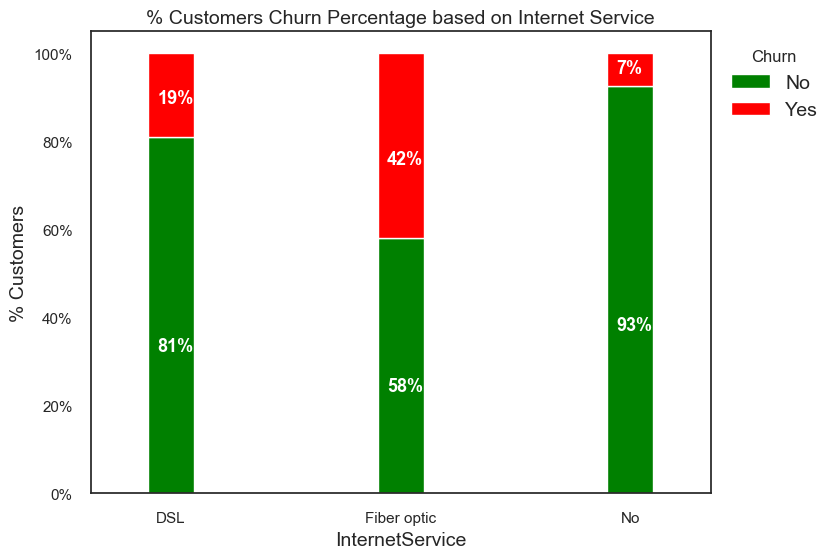

In [32]:
colors = ['green', 'red'] # No, YES

partner_dependents = data.groupby(['InternetService', 'Churn']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn',fontsize =14, bbox_to_anchor=(1.2,1))
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers Churn Percentage based on Internet Service',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.2*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 13)

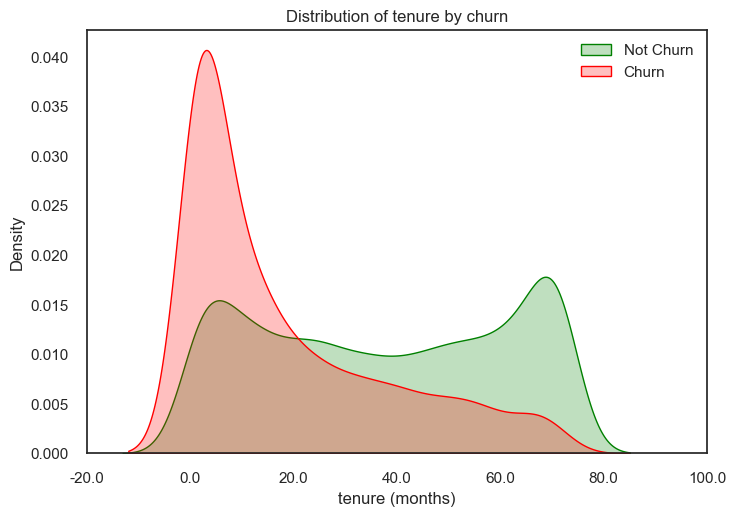

In [33]:
ax = sns.kdeplot(data.tenure[(data["Churn"] == 'No')], gridsize=500, 
                color="green", shade = True)
ax = sns.kdeplot(data.tenure[(data["Churn"] == 'Yes') ],gridsize=500, 
                ax =ax, color="red", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('tenure (months)')
ax.set_title('Distribution of tenure by churn')

plt.xticks(ax.get_xticks(), ax.get_xticks())
plt.show()
# fig.show()

In [34]:
data.tenure[(data["Churn"] == 'Yes') ].sort_values()


4789     1
3592     1
5116     1
5165     1
5186     1
        ..
3890    72
4513    72
6424    72
4610    72
3111    72
Name: tenure, Length: 1869, dtype: int64

# Churn Analysis

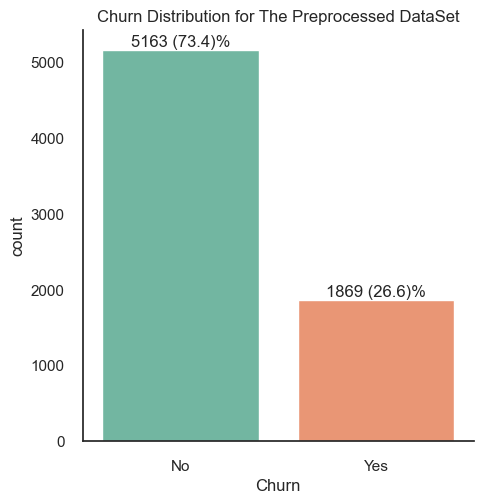

In [35]:
data.dropna(subset=['TotalCharges'], inplace=True)


g = sns.catplot(x="Churn", kind="count", palette='Set2',data=data).set(title='Churn Distribution for The Preprocessed DataSet')
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    totals = sum([int(v.get_height()) for v in c])
    labels = [f'{int(v.get_height()) } ' + f'({(v.get_height() / totals * 100):.1f})%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()


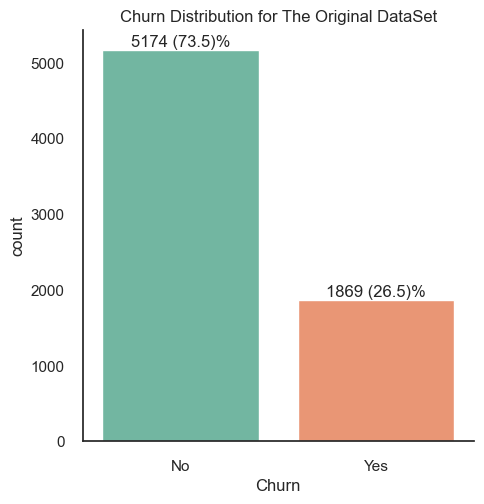

In [36]:
ddd = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
ddd = ddd.drop(columns=['customerID'])

g = sns.catplot(x="Churn", kind="count", palette='Set2',data=ddd).set(title='Churn Distribution for The Original DataSet')
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    totals = sum([int(v.get_height()) for v in c])
    labels = [f'{int(v.get_height()) } ' + f'({(v.get_height() / totals * 100):.1f})%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()


### Train Data

In [37]:
y = data['Churn']
X = data.copy().drop(columns=['Churn'])

X_train_original, X_test, y_train_original, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

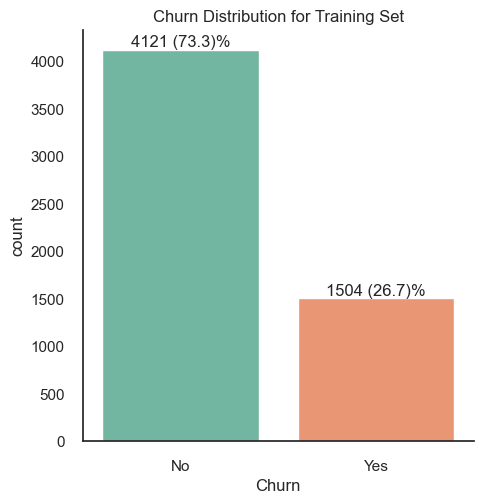

In [38]:
train_data = X_train_original.copy()
train_data['Churn'] = y_train_original

g = sns.catplot(x="Churn", kind="count", palette='Set2',data=train_data, order=['No', 'Yes']).set(title='Churn Distribution for Training Set')
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    totals = sum([int(v.get_height()) for v in c])
    labels = [f'{int(v.get_height()) } ' + f'({(v.get_height() / totals * 100):.1f})%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()

### Test Data

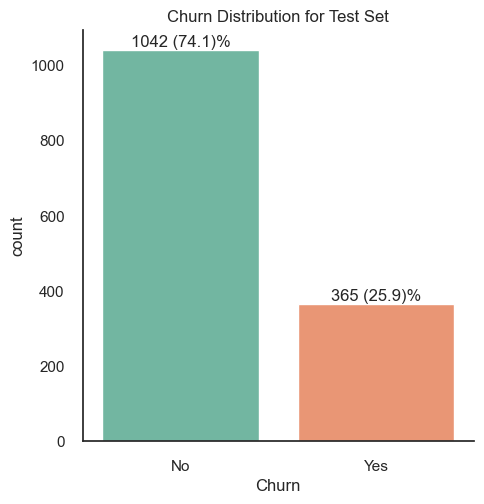

In [39]:

test_data = X_test.copy()
test_data['Churn'] = y_test
g = sns.catplot(x="Churn", kind="count", palette='Set2',data=test_data, order=['No', 'Yes']).set(title='Churn Distribution for Test Set')
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    totals = sum([int(v.get_height()) for v in c])
    labels = [f'{int(v.get_height()) } ' + f'({(v.get_height() / totals * 100):.1f})%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()

In [40]:
# Separate all binary + Categorical Values + Boolean values
#target column
target_col = ["Churn"]
data['Churn'].replace(to_replace='Yes', value=1, inplace=True)
data['Churn'].replace(to_replace='No',  value=0, inplace=True)

y = data['Churn']
X = data.copy().drop(columns=['Churn'])
# Y = data['Churn']
# X = data.copy()

#Binary columns with 2 values
# ['gender',
#  'SeniorCitizen',
#  'Partner',
#  'Dependents',
#  'PhoneService',
#  'PaperlessBilling']
bin_cols = [x for x in X.nunique()[X.nunique() == 2].keys().tolist() if x not in target_col]

#categorical columns
#number of levels in feature to be a categorical feature
nlevels = 11
cat_cols = list(set(X.nunique()[X.nunique()<nlevels].keys().tolist() 
                    + X.select_dtypes(include='object').columns.tolist()))

# ['OnlineBackup',
#  'StreamingMovies',
#  'PaymentMethod',
#  'Contract',
#  'OnlineSecurity',
#  'DeviceProtection',
#  'TechSupport',
#  'StreamingTV',
#  'MultipleLines',
#  'InternetService']
cat_cols = [x for x in cat_cols if x not in target_col + bin_cols]

#numerical columns
# ['tenure', 'MonthlyCharges', 'TotalCharges']
num_cols = [x for x in X.columns if x not in cat_cols + bin_cols + target_col]


from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder


# Categorical Values with OneHotEncoder
# Apply one-hot encoder to each column with categorical data
X = pd.get_dummies(X, columns=cat_cols)


# Transform boolean value with LabelEncoder
label_encoder = LabelEncoder()
for bin_col in bin_cols:
    X[bin_col] = label_encoder.fit_transform(X[bin_col])
# gender: Female = 0, Male = 1, yes=1, no=0

# Transform numerical value with RobustScaler
rs = RobustScaler()
X[num_cols] = rs.fit_transform(X[num_cols])

In [41]:
# X.isnull().sum()
X_train_original, X_test, y_train_original, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# The data is imbalanced, uuse smote method to oversample the data
oversample = SMOTE(random_state=0, k_neighbors=5)
X_train_smote, y_train_smote = oversample.fit_resample(X_train_original, y_train_original)

Text(0, 0.5, 'Count')

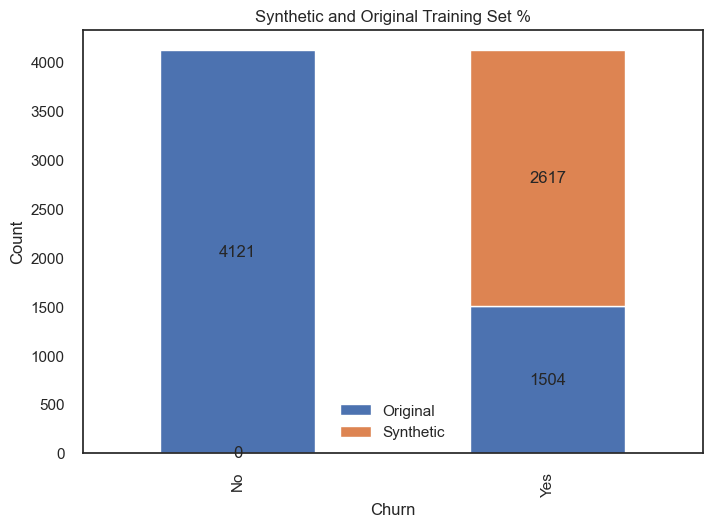

In [42]:
no_train_count = 4121
yes_traini_count = 1504
students = pd.DataFrame({'Original': [no_train_count, yes_traini_count],
                         'Synthetic': [0, no_train_count - yes_traini_count], },
                        index=['No', 'Yes'])
 
 
# create stacked bar chart for students DataFrame
ax = students.plot(kind='bar', stacked=True, )
for c in ax.containers:
    ax.bar_label(c, label_type='center')
    
# Add Title and Labels
plt.title('Synthetic and Original Training Set %')
plt.xlabel('Churn')
plt.ylabel('Count')

In [54]:
def model_performance(model, X_train, y_train, X_test, y_test, model_name="", show_stat=True):
    t0 = time.time()
    result = model.fit(X_train, y_train)
    training_time_seconds = time.time() - t0
    prediction_test = model.predict(X_test)
    # Print the prediction accuracy
    # print ("accuracy score: ", accuracy_score(y_test, prediction_test))
    # print ("f1 score: ", f1_score(y_test, prediction_test))


    #confusion matrix
    conf_matrix = confusion_matrix(y_test, prediction_test)
    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, prediction_test) 
    if show_stat:
        print("Model name: ", model_name)
        print('Algorithm:', type(model).__name__)
        print(classification_report(y_test, prediction_test, digits=4))
        print("Area under the roc curve:", model_roc_auc,"\n")

        ax = sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g')
        ax.set_title('Confusion Matrix\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values (True Label) ');

        ax.xaxis.set_ticklabels(['NOT Churn','Churn'])
        ax.yaxis.set_ticklabels(['NOT Churn','Churn'])
        plt.show()

        #create ROC curve
        probabilities = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test,  probabilities)
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        plt.show()
        
        try:

        # viz = FeatureImportances(model, topn=10)
            viz = FeatureImportances(model, relative=False)

            viz.fit(X_test, y_test)
            viz.show()
        except:
            pass
        
    accuracy = accuracy_score(y_test, prediction_test)
    recallscore = recall_score(y_test, prediction_test)
    precision = precision_score(y_test, prediction_test)
    roc_auc = model_roc_auc
    f1score = f1_score(y_test, prediction_test) 
    df = pd.DataFrame({"Model"           : [model_name],
                       "Accuracy"        : [accuracy],
                       "Recall"          : [recallscore],
                       "Precision"       : [precision],
                       "f1-score"        : [f1score],
                       "Roc_auc"         : [roc_auc],
                       "Training Time(s)"         : [training_time_seconds],
                      })
    return df

In [44]:
num_rfe_features_to_select = 15
rfe = RFE(LogisticRegression(max_iter=10000), n_features_to_select=num_rfe_features_to_select, step=1)
rfe = rfe.fit(X_train_original, y_train_original.values.ravel())

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support": rfe.support_,
                        "columns": X_train_original.columns,
                        "ranking": rfe.ranking_,
                       })

cols_rfe = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()

Model name:  AdaBoostClassifier (SMOTE RFE)
Algorithm: AdaBoostClassifier
              precision    recall  f1-score   support

           0      0.930     0.745     0.827      1042
           1      0.536     0.841     0.655       365

    accuracy                          0.770      1407
   macro avg      0.733     0.793     0.741      1407
weighted avg      0.828     0.770     0.782      1407

Area under the roc curve: 0.7929087897352299 



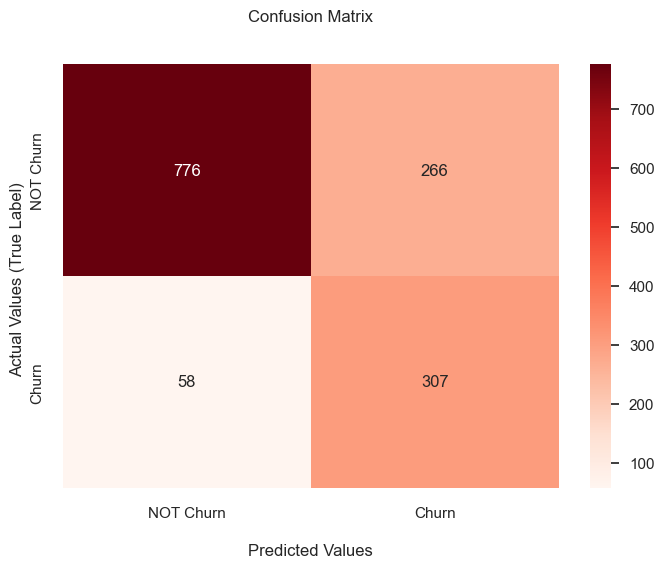

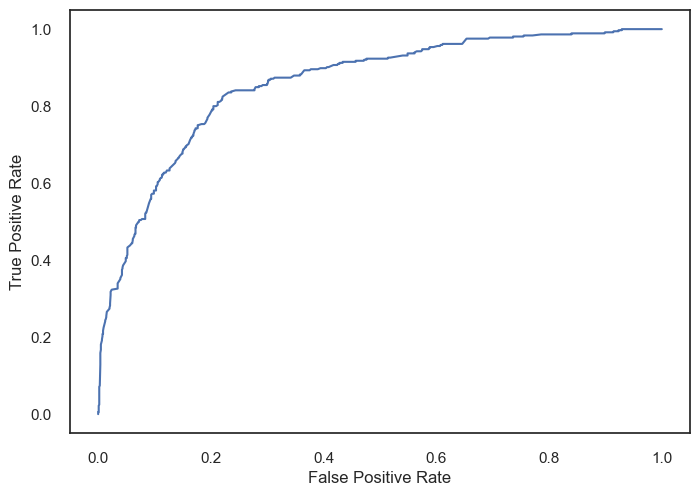

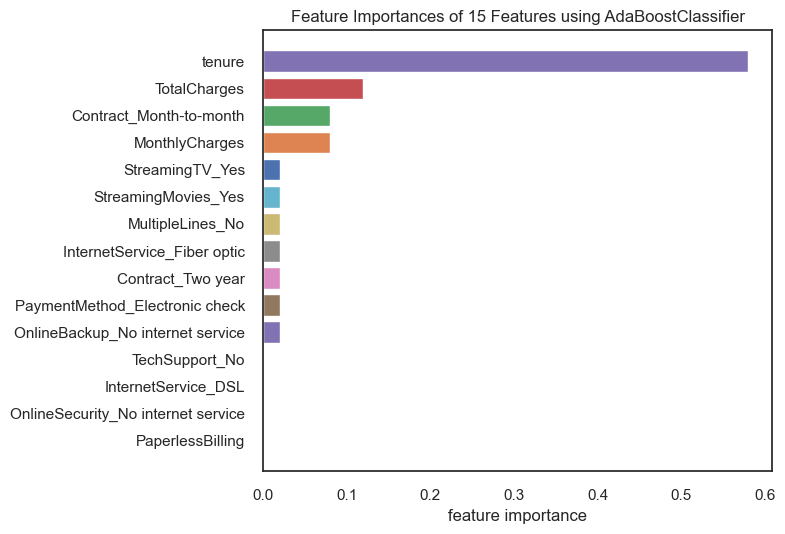

In [45]:
random_state = 50
model = AdaBoostClassifier(random_state=random_state, )

name = type(model).__name__ + ' (SMOTE RFE)'
df = model_performance(model, X_train_smote[cols_rfe], y_train_smote, X_test[cols_rfe], y_test, name, show_stat=True)
            

Model name:  AdaBoostClassifier (SMOTE RFE)
Algorithm: AdaBoostClassifier
              precision    recall  f1-score   support

           0      0.907     0.776     0.837      1042
           1      0.548     0.773     0.641       365

    accuracy                          0.775      1407
   macro avg      0.727     0.774     0.739      1407
weighted avg      0.814     0.775     0.786      1407

Area under the roc curve: 0.7744971472142613 



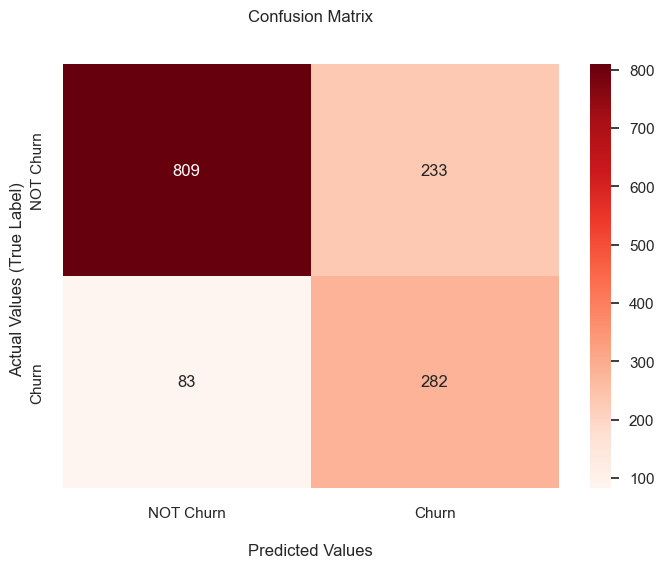

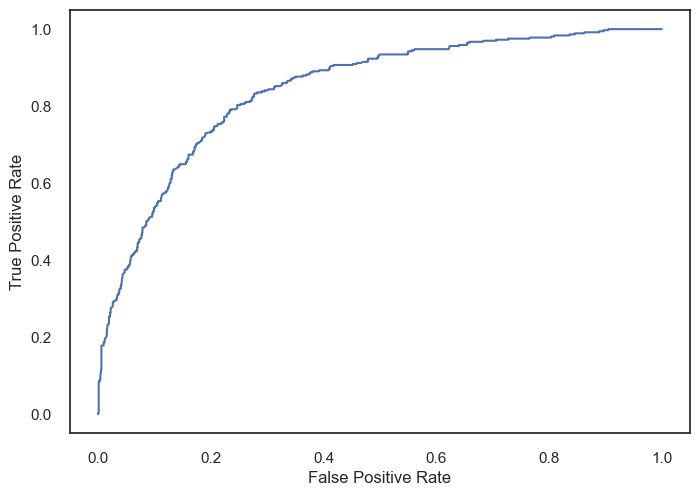

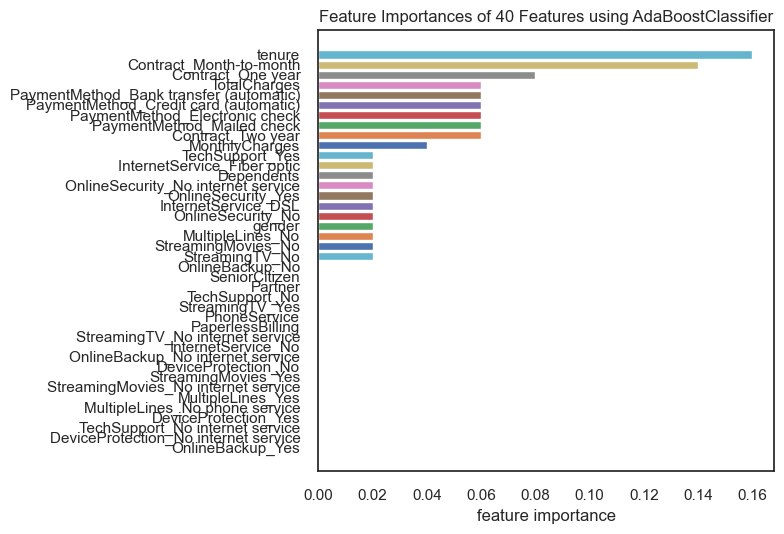

In [46]:
df = model_performance(model, X_train_smote, y_train_smote, X_test, y_test, name, show_stat=True)


In [47]:
result = model.fit(X_train_smote[cols_rfe], y_train_smote)
prediction_test = model.predict(X_test[cols_rfe])

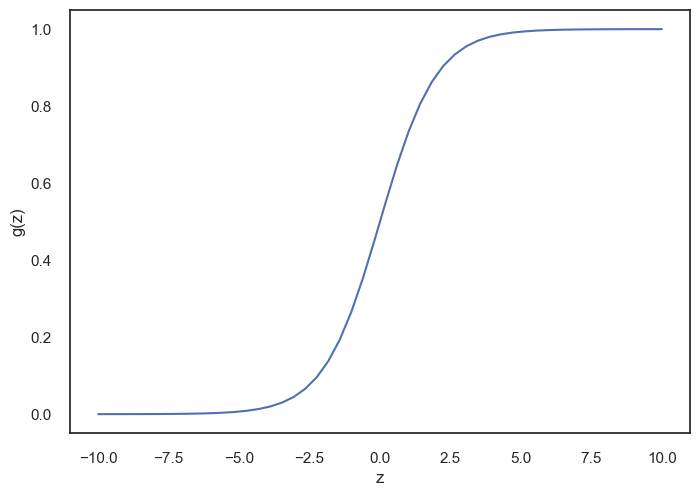

In [48]:
def sig(x):
 return 1/(1 + np.exp(-x))

x = np.linspace(-10, 10, 50)   
p = sig(x)
plt.xlabel("z") 
plt.ylabel("g(z)")  
plt.plot(x, p) 
plt.show()

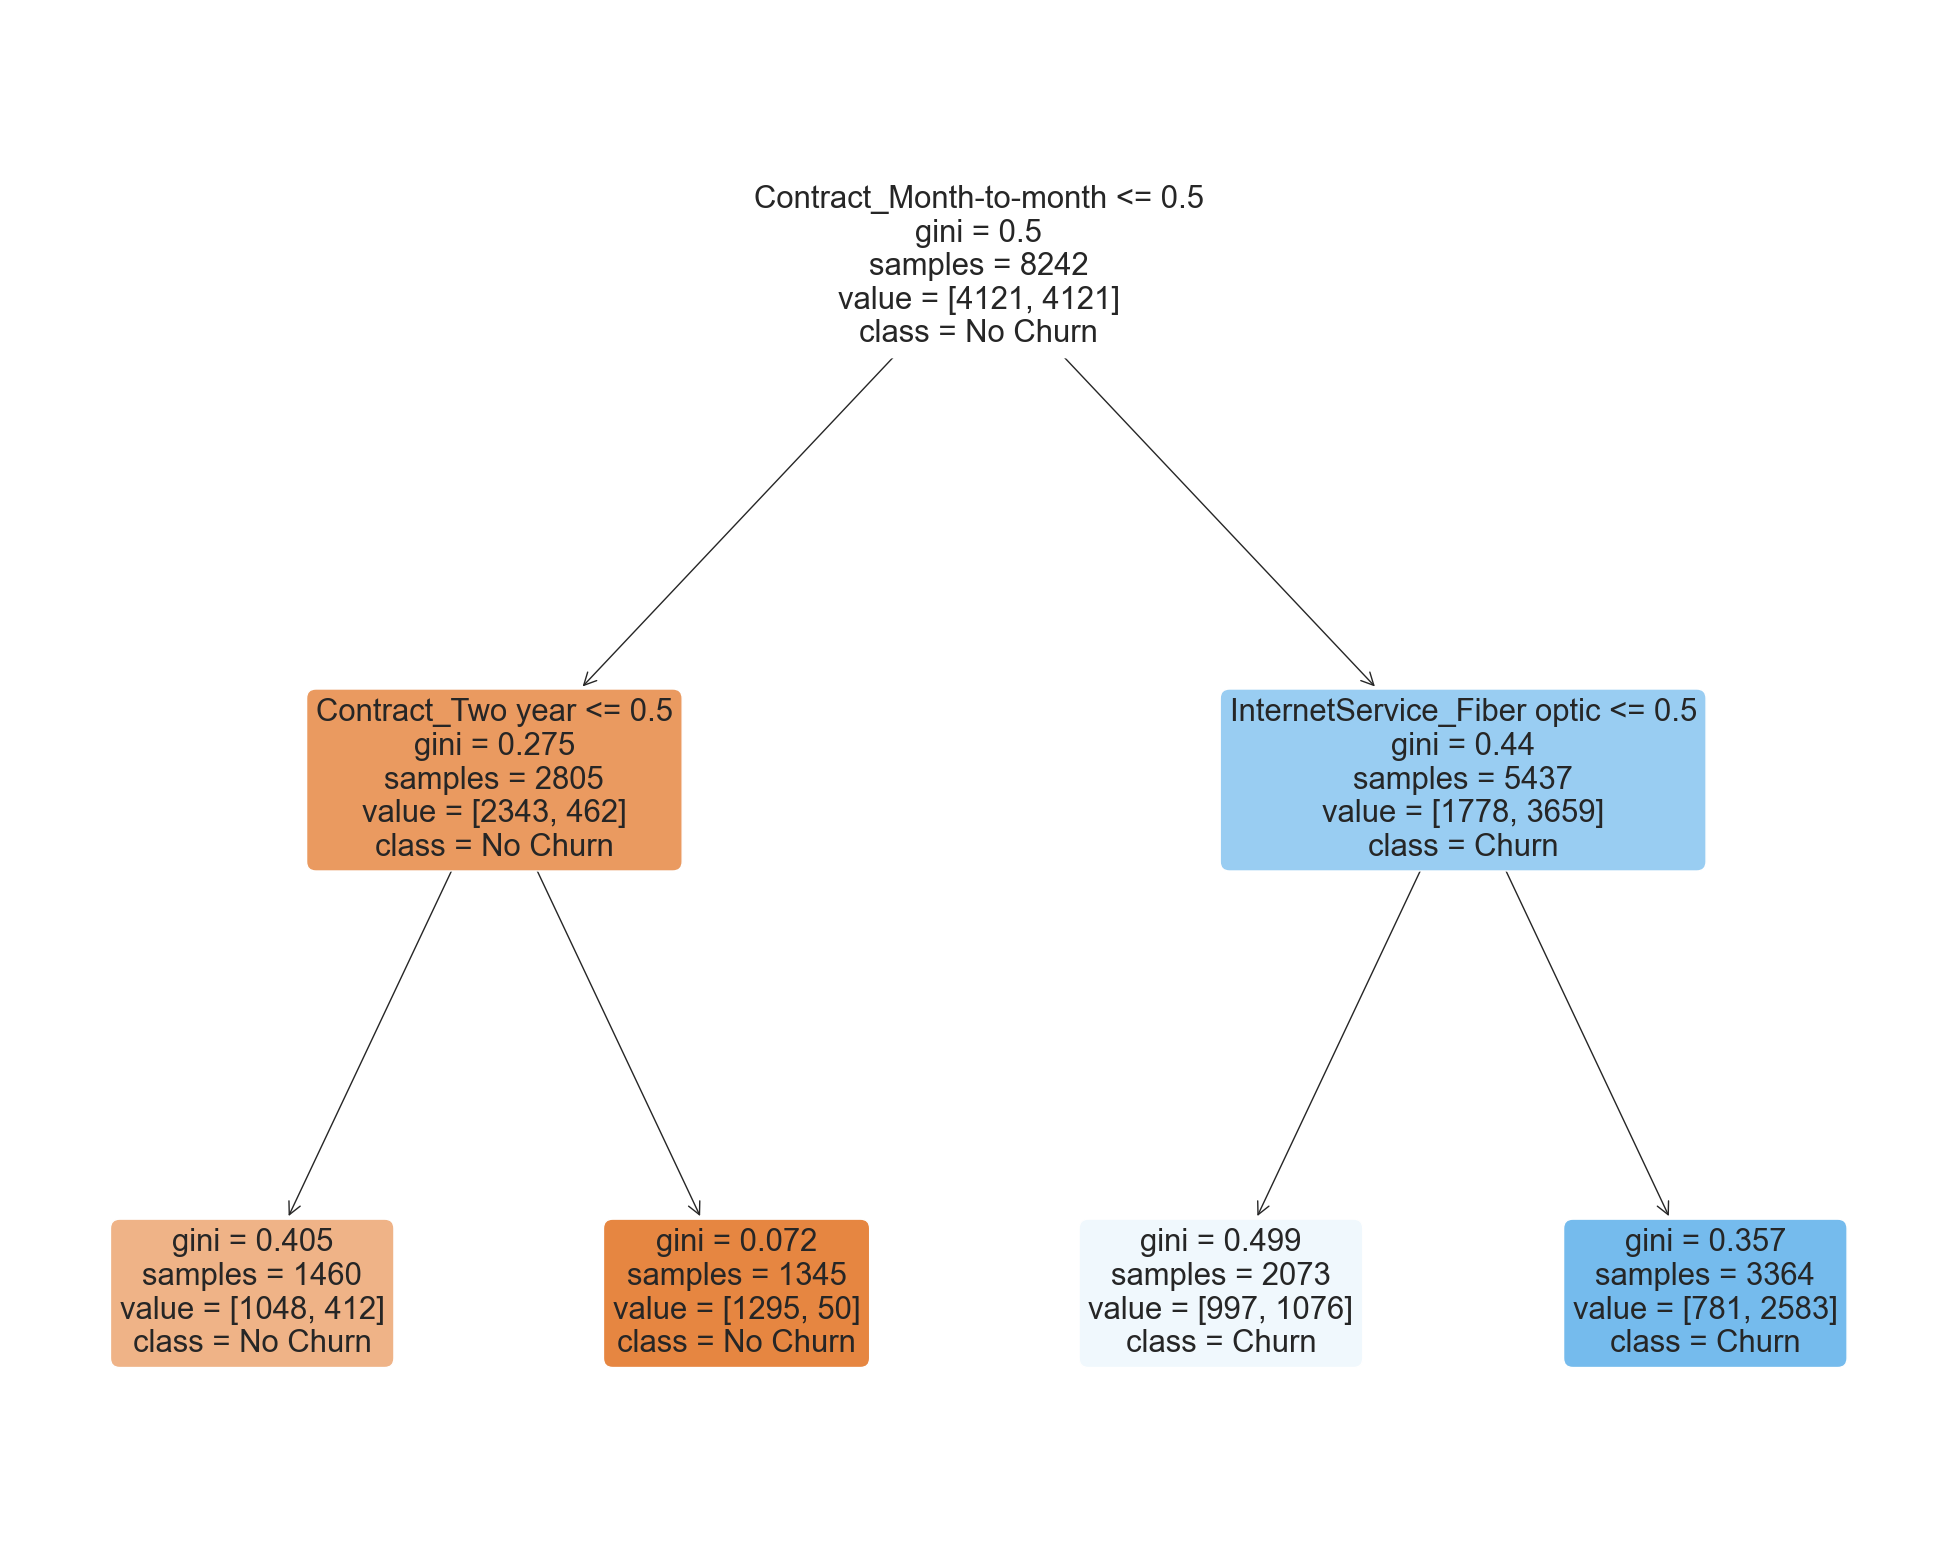

In [49]:
model = DecisionTreeClassifier(max_depth = 2, random_state = random_state,splitter = "best", criterion = "gini")
model.fit(X_train_smote[cols_rfe], y_train_smote)


fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=cols_rfe,  
                   class_names=['No Churn', 'Churn'],
                   filled=True, rounded=True)


In [50]:
cols_rfe

['tenure',
 'PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges',
 'OnlineBackup_No internet service',
 'PaymentMethod_Electronic check',
 'Contract_Month-to-month',
 'Contract_Two year',
 'OnlineSecurity_No internet service',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'MultipleLines_No',
 'StreamingMovies_Yes',
 'StreamingTV_Yes',
 'TechSupport_No']

Model name:  AdaBoostClassifier (SMOTE RFE)
Algorithm: LogisticRegression
              precision    recall  f1-score   support

           0      0.855     0.911     0.882      1042
           1      0.687     0.559     0.616       365

    accuracy                          0.819      1407
   macro avg      0.771     0.735     0.749      1407
weighted avg      0.811     0.819     0.813      1407

Area under the roc curve: 0.7348263350248468 



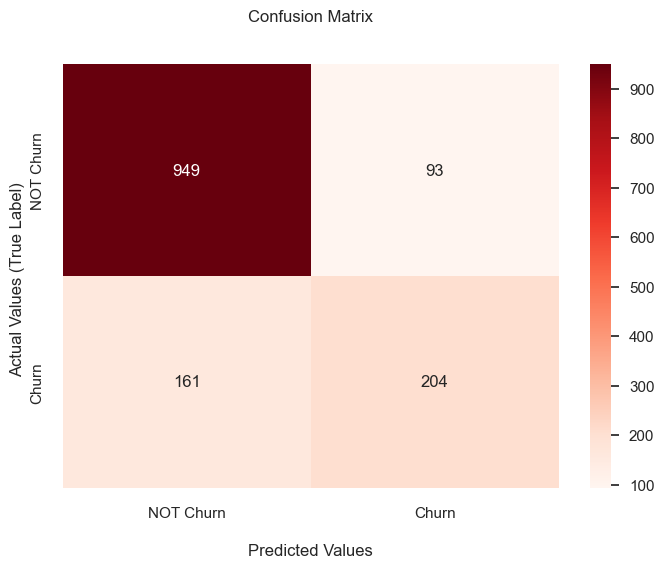

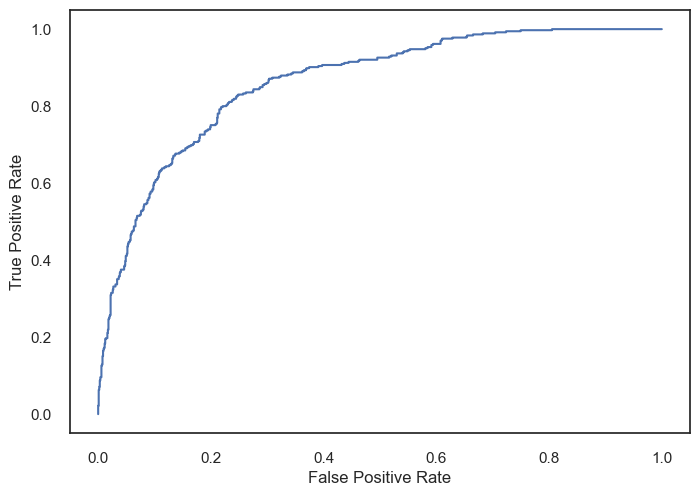

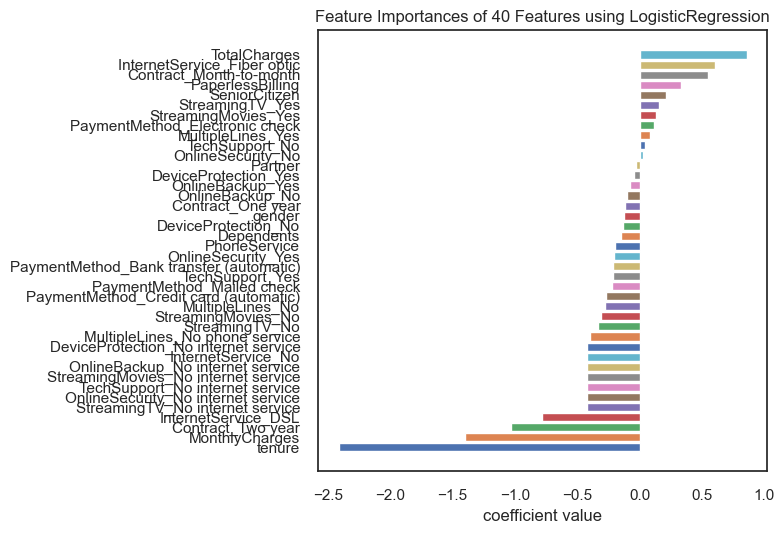

In [52]:
lg_params = {'solver': 'liblinear', 'penalty': 'l2', 'C': 69.51927961775606}
model=LogisticRegression(max_iter=10000, **lg_params)
df = model_performance(model, X_train_original, y_train_original, X_test, y_test, name, show_stat=True)


Model name:  AdaBoostClassifier (SMOTE RFE)
Algorithm: LogisticRegression
              precision    recall  f1-score   support

           0     0.8855    0.8464    0.8656      1042
           1     0.6107    0.6877    0.6469       365

    accuracy                         0.8053      1407
   macro avg     0.7481    0.7671    0.7562      1407
weighted avg     0.8142    0.8053    0.8088      1407

Area under the roc curve: 0.7670601845765519 



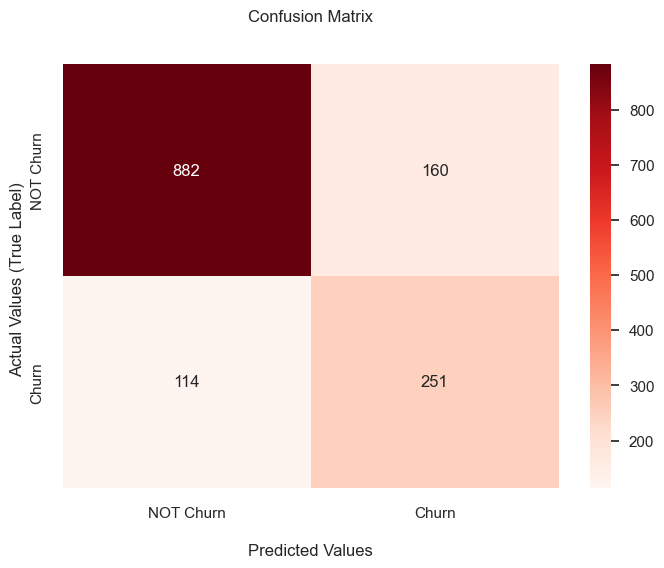

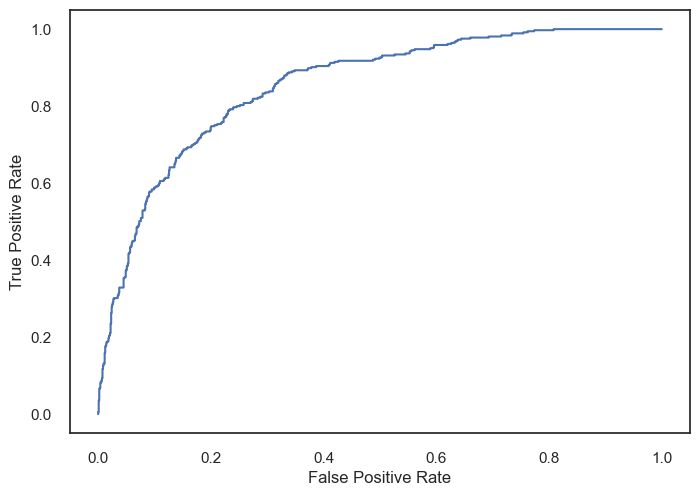

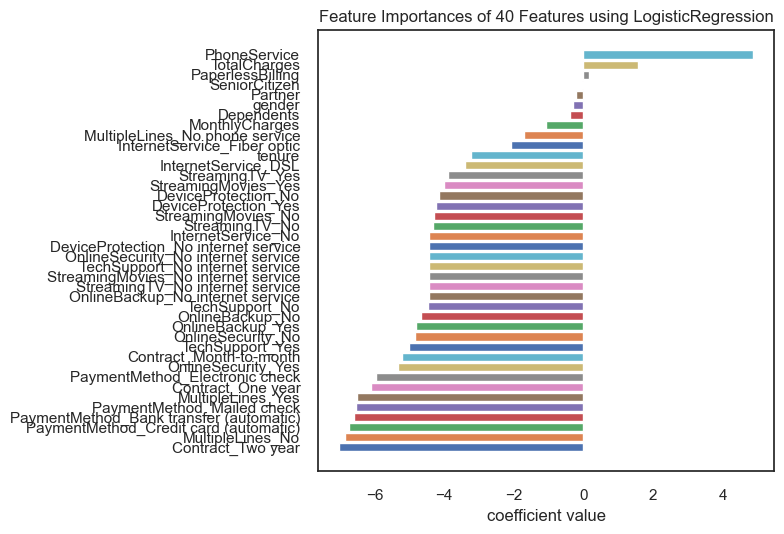

In [55]:
lg_params = {'solver': 'liblinear', 'penalty': 'l2', 'C': 69.51927961775606}
model=LogisticRegression(max_iter=10000, **lg_params)
df = model_performance(model, X_train_smote, y_train_smote, X_test, y_test, name, show_stat=True)


Model name:  AdaBoostClassifier (SMOTE RFE)
Algorithm: LogisticRegression
              precision    recall  f1-score   support

           0     0.9249    0.7447    0.8251      1042
           1     0.5317    0.8274    0.6474       365

    accuracy                         0.7662      1407
   macro avg     0.7283    0.7861    0.7362      1407
weighted avg     0.8229    0.7662    0.7790      1407

Area under the roc curve: 0.7860594746667369 



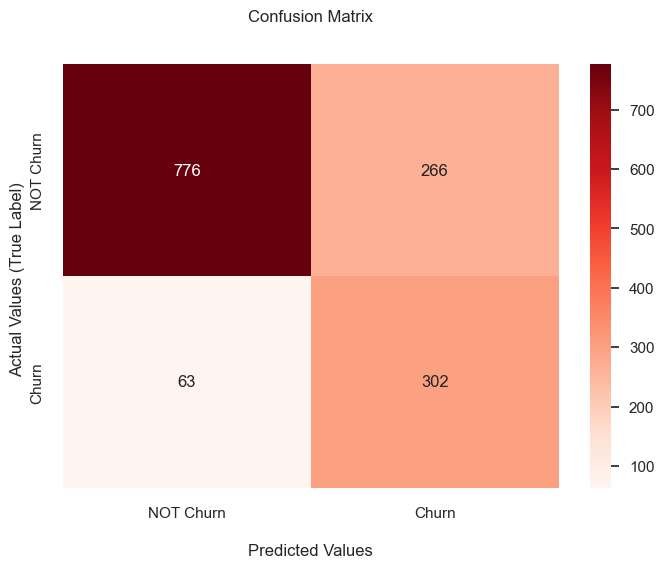

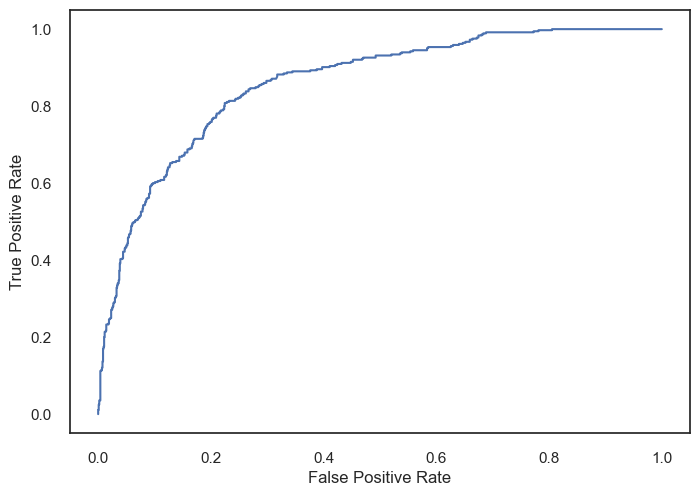

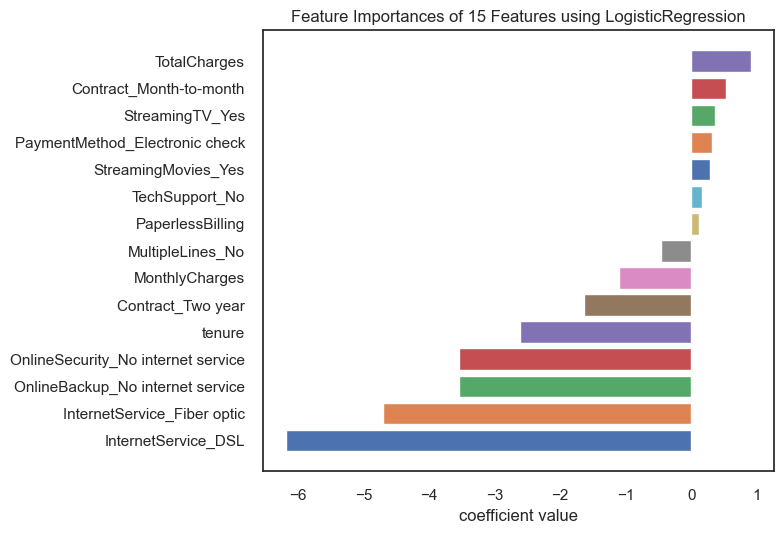

In [56]:
lg_params = {'solver': 'liblinear', 'penalty': 'l2', 'C': 69.51927961775606}
model=LogisticRegression(max_iter=10000, **lg_params)
df = model_performance(model, X_train_smote[cols_rfe], y_train_smote, X_test[cols_rfe], y_test, name, show_stat=True)
